# Imports and creating dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/intel_places_ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "seg_" + x + "/seg_" + x ),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Creating and training models (VGG and MobileNet2)

In [ ]:
vgg_model = models.vgg16(pretrained=True)

In [ ]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg_model.parameters():
  param.requires_grad = False

In [ ]:
vgg_model.classifier[6] = nn.Linear(4096, len(class_names))
vgg_model.classifier.add_module('7', nn.LogSoftmax(dim=1))

In [ ]:
vgg_model.to('cuda:0')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())

In [ ]:
from copy import deepcopy
train_loader = dataloaders['train']

def train_and_check(model, loss_func, optim, epochs=15):
  '''
  Function to train and check results
  Parameters:
    :param model: model to train
    :param loss_func: loss function
    :param optim: optimizer for gradients
    :param epochs: number of epochs to train (default=15)
  Returns:
    model(last model): trained model with best accuracy
    history: list containing avg train loss and accuracy
  '''
  model.train()
  history = []
  for epoch in range(epochs):
    last_model = deepcopy(model)
    print(f"Epoch {epoch + 1}/{epochs}")


    train_loss = 0.
    # train_acc = 0.
    for i, (inputs, labels) in enumerate(train_loader):
      if i % 50 == 0:
        print(i)

      inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')

      optim.zero_grad()
      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      loss.backward()
      optim.step()

      train_loss += loss.item() * inputs.size(0)
      # _, preds = torch.max(outputs.data, dim=1)
      # corects = preds.eq(labels.data.view_as(preds))
      # acc = torch.mean(corects.type(torch.FloatTensor))
      # train_acc += acc.item() * inputs.size(0)
    
    avg_train_loss = train_loss / len(image_datasets['train']) 
    print(avg_train_loss)
      # avg_train_acc = train_acc / len(image_datasets['train'])
    history.append(avg_train_loss)
    if epoch >= 1:
      if avg_train_loss > history[-2]:
        return last_model, history
    
  return model, history



In [ ]:
trained_model = train_and_check(vgg_model, loss_fn, optimizer, 5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
0.4555241545766354
Epoch 2/5
0
50
100
150
200
0.3938673297654808
Epoch 3/5
0
50
100
150
200
0.3899435758667158
Epoch 4/5
0
50
100
150
200
0.3770262523890901
Epoch 5/5
0
50
100
150
200
0.38404363461747815


In [ ]:
trained_vgg_model = trained_model[0].to('cuda:0')

In [ ]:
def predict(model, dataloader):
  all_preds = torch.tensor([]).to('cuda:0')
  true_vals = torch.tensor([]).to('cuda:0')
  with torch.no_grad():
    model.eval()
    for (X, y) in dataloader:
      X, y = X.to('cuda:0'), y.to('cuda:0')
      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
  return all_preds, true_vals

In [ ]:
outputs, labels = predict(trained_vgg_model, dataloaders['test'])
#outputs = outputs.to('cuda:0')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mobile_net = models.mobilenet_v2(pretrained=True)

In [ ]:
for param in mobile_net.parameters():
  param.requires_grad = False

In [ ]:
mobile_net.classifier[1] = nn.Linear(1280, len(class_names))
mobile_net.classifier.add_module('2', nn.LogSoftmax(dim=1))

In [ ]:
mobile_net.to('cuda:0')

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
summary(mobile_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
mobile_loss_fn = nn.CrossEntropyLoss()
mobile_optimizer = optim.Adam(mobile_net.parameters())
trained_mobile_net = train_and_check(mobile_net, mobile_loss_fn, mobile_optimizer, 5)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
0.5790586093676403
Epoch 2/5
0
50
100
150
200
0.41858142991566194
Epoch 3/5
0
50
100
150
200
0.40085522906946075
Epoch 4/5
0
50
100
150
200
0.4082711544928556


In [ ]:
trained_mobile_net, mobile_net_history = trained_mobile_net
trained_mobile_net.to('cuda:0')

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
mob_outputs, mob_labels = predict(trained_mobile_net, dataloaders['test'])
#outputs = outputs.to('cuda:0')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Classification report and ROC curves for models

In [ ]:
print('Classification report for VGG model\n\n')
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))
print('Confusion matrix for VGG model\n\n')
print(confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

Classification report for VGG model


              precision    recall  f1-score   support

   buildings       0.93      0.90      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.89      0.81      0.85       553
    mountain       0.84      0.89      0.86       525
         sea       0.95      0.98      0.96       510
      street       0.92      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Confusion matrix for VGG model


[[0.90160183 0.         0.         0.00228833 0.00228833 0.09382151]
 [0.         0.99367089 0.         0.00632911 0.         0.        ]
 [0.00180832 0.00180832 0.8119349  0.15189873 0.03254973 0.        ]
 [0.00190476 0.00190476 0.08952381 0.89142857 0.01333333 0.00190476]
 [0.00196078 0.00196078 0.01176471 0.00784314 0.97647059 0.        ]
 [0.05189621 0.00199601 0.00199601 0.    

In [ ]:
def plot_roc_curves(fpr_tpr, roc_auc):
  colors = ['blue', 'yellow', 'green', 'pink', 'orange', 'black']
  plt.title('Receiver Operating Characteristic')
  for i in range(6):
    plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], colors[i], label = 'ROC curve for class %i AUC = %0.2f' %(i, roc_auc[i]))
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

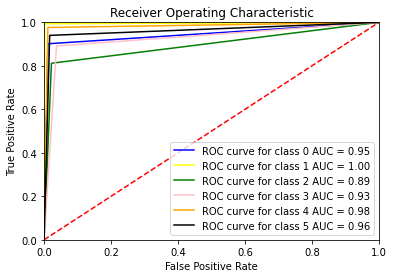

In [ ]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]

fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]

plot_roc_curves(fpr_tpr, roc_auc)

In [ ]:
print('Classification report for MobileNet model\n\n')
_, mob_outs = torch.max(mob_outputs, dim=1)
print(classification_report(mob_labels.cpu().numpy(), mob_outs.cpu().numpy(), target_names=class_names))
print('Confusion matrix for VGG model\n\n')
print(confusion_matrix(mob_labels.cpu().numpy(), mob_outs.cpu().numpy(), normalize='true'))

Classification report for MobileNet model


              precision    recall  f1-score   support

   buildings       0.87      0.94      0.90       437
      forest       0.99      1.00      0.99       474
     glacier       0.94      0.68      0.79       553
    mountain       0.73      0.95      0.83       525
         sea       0.96      0.93      0.94       510
      street       0.94      0.89      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.89      3000
weighted avg       0.90      0.89      0.89      3000

Confusion matrix for VGG model


[[0.9382151  0.         0.         0.00228833 0.00228833 0.05720824]
 [0.         0.9978903  0.         0.0021097  0.         0.        ]
 [0.00723327 0.00361664 0.67631103 0.28571429 0.02350814 0.00361664]
 [0.00380952 0.00190476 0.03047619 0.95238095 0.01142857 0.        ]
 [0.01176471 0.00196078 0.01372549 0.04313725 0.92941176 0.        ]
 [0.10179641 0.00199601 0.         

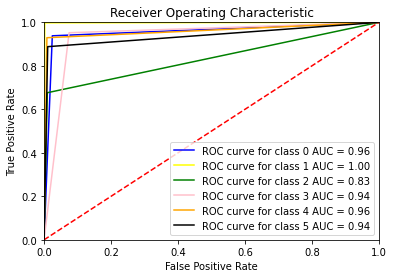

In [ ]:
mob_labels_plot = [(mob_labels.cpu().numpy() == i).astype(float) for i in range(6)]
mob_outs_plot = [(mob_outs.cpu().numpy() == i).astype(float) for i in range(6)]

fpr_tpr = [roc_curve(mob_labels_plot[i], mob_outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]

plot_roc_curves(fpr_tpr, roc_auc)

# Visualizing model predictions

VGG model predictions

In [ ]:
X, y = next(iter(dataloaders['test']))
X = X.to('cuda:0')

probas = trained_model[0](X)

_, preds = torch.max(probas, dim=1)

def show(images, labels, predicts):
  fig = plt.figure(figsize=(16,12), dpi=1600)
  axes = []
  k = 0
  for i in range(3):
    for j in range(4):
      axes.append(plt.subplot2grid((3, 4), (i, j)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_ylabel(labels[k])
      axes[k].set_xlabel(predicts[k])
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()
y = [class_names[x] for x in y[:12]]
preds = [class_names[x] for x in preds[:12]]
show(X.to('cpu')[:12], y, preds)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualizing MobileNet model predictions

In [ ]:
_, mob_preds = torch.max(trained_mobile_net(X.to('cuda:0')), dim=1)
show(X.to('cpu')[:12], y, [class_names[x] for x in mob_preds[:12]])